
# **强化学习——DQN玩合成大西瓜**
**作者：** [莱可可](https://github.com/RedContritio)<br>
**日期：** 2022.11 <br>
**摘要：** 使用 DQN 算法训练 AI 玩合成大西瓜

## **一、介绍**
本案例展示了使用DQN玩合成大西瓜的一个实现。

### Deep Q-Network (DQN 算法)

DQN 是基于深度学习的 Q 学习算法，主要结合了值函数近似和神经网络技术，并采用目标网络和经验回放的方法进行训练。
- 目标网络：使用一个固定的 Q 神经网络来计算目标值，这样可以减少训练时的波动。
- 经验回放：将经验存储在一个缓冲区中，然后从缓冲区中随机采样，这样可以减少相关性，使得训练更加稳定。


### 合成大西瓜 - 任务介绍

合成大西瓜玩法与《2048》《俄罗斯方块》类似，玩家每次可以从游戏画面顶部放下一个水果，玩家可以控制放下水果的横坐标。

游戏中共有11种水果，包括葡萄、樱桃等，最终目标是合成大西瓜。

每当两个相同类别的水果发生碰撞时，这两个水果将会合成为体积略大的新水果，例如两个葡萄碰撞将合成一个樱桃。

在本教程任务中，agent 需要学会将水果从合适的位置（横坐标）放下，使水果能顺利合成。

本教程的数据流方向如下所示（不含训练部分）：

![数据流示意图](./resources/illustrations/dataflow.jpg)

## **二、环境配置**

本教程依赖的非 python 官方包如下：

- pymunk: python 2D物理引擎，用于处理物体碰撞等运动
- opencv-python: 图形库，用于绘制界面与交互
- numpy: 数值计算库，主要用于图像处理和模型数据处理

In [1]:
%pip install paddlepaddle pymunk opencv-python numpy matplotlib

In [2]:
import random
import typing
import enum
import collections
from threading import Lock
import base64
import math
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymunk
import cv2
import paddle
from paddle import nn
from paddle import optimizer

print(paddle.__version__)

2.3.2


## **三、实现游戏本体**

### 3.1 事件系统

事件系统是对游戏与用户交互的抽象，包括鼠标点击与鼠标移动。

In [3]:
class EventType(enum.Enum):
    # 左键单击
    LBUTTONDOWN = (1,)
    # 鼠标移动
    MOUSEMOVE = (2,)
    # 右键单击
    RBUTTONDOWN = (3,)


class Event:
    def __init__(self, type: EventType):
        self.type = type


# 鼠标事件
class MouseEvent(Event):
    def __init__(self, type: EventType, pos: typing.Tuple[int, int]):
        self.pos = pos
        super().__init__(type)


# 事件系统基类
class GameEventBase:
    def __init__(self):
        self.__events = []

    # 添加一个事件
    def add_event(self, event: Event):
        self.__events.append(event)

    # 获取（上一次获取之后）新发生的事件
    # 该操作会清空现有事件列表
    @property
    def events(self) -> typing.List[Event]:
        _events = self.__events[:]
        self.__events.clear()
        return _events

### 3.2 图像渲染

游戏的图形界面绘制需要一些辅助函数，如下：

- `mix`: 将 `background` 和 `foreground` 基于透明度混合（并给 `foreground` 额外乘算 `alpha` 的透明度），直接在 `background` 上修改
- `cover`: 将 `foreground` 基于透明度覆盖到 `background` 上（并给 `foreground` 额外乘算 `alpha` 的透明度），直接在 `background` 上修改
- `intersectRect`: 计算两个矩形框 `(x, y, w, h)` 的相交矩形框 `(ix, iy, iw, ih)`
- `putText2`: 在 `image` 上以 `center` 为中心，绘制文字 `text` （用法同 `cv2.putText` ）
- `putInverseColorText`: 在 `image` 上基于 `pos` 点，调用 `putTextFunc` 绘制文字 `text`，文字与 `image` 反色

In [4]:
# 将 background 和 foreground 基于透明度混合（并给 foreground 额外乘算 alpha 的透明度），直接在 background 上修改
def mix(
    background: np.ndarray, foreground: np.ndarray, alpha: float = 1.0
) -> None:
    alpha_back = background[:, :, 3] / 255.0
    alpha_fore = (foreground[:, :, 3] / 255.0) * alpha

    for c in range(3):
        background[:, :, c] = np.ubyte(
            alpha_fore * foreground[:, :, c]
            + alpha_back * background[:, :, c] * (1 - alpha_fore)
        )
    background[:, :, 3] = np.ubyte(
        (1 - (1 - alpha_fore) * (1 - alpha_back)) * 255
    )


# 将 foreground 基于透明度覆盖到 background 上（并给 foreground 额外乘算 alpha 的透明度），直接在 background 上修改
def cover(
    background: np.ndarray, foreground: np.ndarray, alpha: float = 1.0
) -> None:
    foreground_colors = foreground[:, :, :3]
    alpha_channel = (foreground[:, :, 3] / 255.0) * alpha
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    background[:, :, :3] = (
        background[:, :, :3] * (1 - alpha_mask) + foreground_colors * alpha_mask
    )


# 计算两个矩形框 (x, y, w, h) 的相交矩形框 (ix, iy, iw, ih)
def intersectRect(
    rect1: typing.List[int], rect2: typing.List[int]
) -> typing.List[int]:
    l1, t1, b1, h1 = rect1
    r1, b1 = l1 + b1, t1 + h1
    l2, t2, b2, h2 = rect2
    r2, b2 = l2 + b2, t2 + h2

    l, r = max(l1, l2), min(r1, r2)
    t, b = max(t1, t2), min(b1, b2)

    return [l, t, max(0, r - l), max(0, b - t)]


# 在 image 上以 center 为中心，绘制文字 text （用法同 cv2.putText ）
def putText2(
    image: np.ndarray,
    text: str,
    center: typing.List[int],
    font_face: int = 0,
    font_scale: float = 1.0,
    color: typing.List[int] = (255, 255, 255),
    thickness: int = 1,
) -> None:
    INNER_LINE_MARGIN = 5
    x, y = center
    lines = text.splitlines()

    sizes = [
        cv2.getTextSize(line, font_face, font_scale, thickness)[0]
        for line in lines
    ]

    h_sum = (
        sum([size[1] for size in sizes]) + (len(sizes) - 1) * INNER_LINE_MARGIN
    )
    w_max = max([size[0] for size in sizes])

    y_base = y - h_sum // 2

    for i, (w, h) in enumerate(sizes):
        cv2.putText(
            image,
            lines[i],
            (x - w // 2, y_base),
            font_face,
            font_scale,
            color,
            thickness,
        )
        y_base += h + INNER_LINE_MARGIN


# 在 image 上基于 pos 点，调用 putTextFunc 绘制文字 text，文字与 image 反色
def putInverseColorText(
    image: np.ndarray,
    text: str,
    pos: typing.List[int],
    font_face: int = 0,
    font_scale: float = 1.0,
    thickness: int = 1,
    putTextFunc: typing.Callable = putText2,
) -> None:
    mask = np.zeros((*image.shape[:2], 3), dtype=np.uint8)
    putTextFunc(
        mask, text, pos, font_face, font_scale, (255, 255, 255), thickness
    )

    image[:, :, :3] = mask + (2 * (0.5 - mask / 255.0)) * image[:, :, :3]

### 3.3 伪随机数生成器

自定义伪随机数生成器，使用二次同余生成器[[1]](#1)（quadratic congruential generator）算法，便于控制随机过程。

二次同余生成器的算法原理如下： $y_n = (a * y_{n-1}^2 + b *y_{n-1} + c) \mod p     ,n > 0$

其中，$a$, $b$, $c$ 分别为二次项系数、一次项系数与常数项。

在本教程实现中，取 $a = 1, b = c = 0, p = p_1 * p_2$，则算法退化为 $y_n = y_{n-1}^2 \mod (p_1 * p_2)     ,n > 0$

令 $p_1$、$p_2$ 为两个大质数，则生成的随机数周期会更大。

<a id="1">[1]</a> 
Eichenauer, J., Lehn, J. On the structure of quadratic congruential sequences. Manuscripta Math 58, 129–140 (1987).

In [5]:
class PRNG:
    def __init__(self):
        self.s = 1234  # y_0，取为 1234
        self.p = 999979  # p_1，第一个大质数
        self.q = 999983  # p_2，第二个大质数
        self.m = self.p * self.q  # p，模数

    # 基于 x 的哈希结果，获得一个浮点数
    def hash(self, x: any) -> float:
        y = base64.encodebytes(bytes(str(x).encode("utf8")))
        z = 0
        for i, v in enumerate(y):
            z += v * math.pow(128, i)
        return z

    # 传入可哈希变量 seed，以此初始化 s (即 y_0)。
    def seed(self, seed: any = datetime.datetime.now()):
        y = 0
        z = 0
        while y % self.p == 0 or y % self.q == 0 or y == 0 or y == 1:
            y = (self.hash(seed) + z) % self.m
            z += 1

        self.s = y  # 初始化 y_0

        # 跳过前 10 个随机数，用来混淆
        [self.next() for _ in range(10)]

    # 获取 [0, 1) 的随机浮点数
    def next(self) -> float:
        self.s = (self.s * self.s) % self.m
        return self.s / self.m

    # 获取 [l = 0, r = 1) 的随机浮点数
    def random(self, l: float = 0, r: float = 1) -> float:
        return self.next() * (r - l) + l

    # 获取 [l = 0, r = 2) 的随机整数
    def randint(self, l: int = 0, r: int = 2) -> int:
        return int(math.ceil(self.random(l, r)))

### 3.4 实现水果类

#### 3.4.1 水果参数

定义各种水果的半径、尺寸与对应图片。

（列表中首个元素无意义，用于占位 `type` `0`）

In [6]:
# 水果半径 r
FRUIT_RADIUS = [
    int(1.5 * r) for r in [-1, 10, 15, 21, 23, 29, 35, 37, 50, 59, 60, 78]
]
# 水果尺寸 (w, h)
FRUIT_SIZES = [(2 * r, 2 * r) for r in FRUIT_RADIUS]

# 水果图像路径
FRUIT_IMAGE_PATHS = [f"resources/images/{i:02d}.png" for i in range(11)]

# 水果图像原图 (np.ndarray)
FRUIT_RAW_IMAGES = [
    cv2.imread(FRUIT_IMAGE_PATHS[i], -1) if i > 0 else None for i in range(11)
]

# 水果基于尺寸缩放后的图像 (np.ndarray)
FRUIT_IMAGES = [
    None if img is None else cv2.resize(img, FRUIT_SIZES[i])
    for i, img in enumerate(FRUIT_RAW_IMAGES)
]

#### 3.4.2 水果类定义

定义所有水果的类 `class Fruit`。

每个水果对应一个该类型实例，主要用于描述水果对象的位置。

其中，水果的种类 `type` 为 $[1, 11]$，其中 $1$ 是葡萄，$11$ 是大西瓜。


合成得分：
- 当两个种类为 $x$ 的水果碰撞时，合成出一个种类为 $x+1$ 的新水果，并在游戏中获得 $x+1$ 分；
- 特别的，当 $x=10$ 时，合成出的新水果为 $11$ （大西瓜），并在游戏中获得 $100$ 分。

In [7]:
class Fruit:
    # 初始化时，传入水果种类 type 与水果位置 (x, y)
    def __init__(self, type: int, x: int, y: int) -> None:
        self.type = type
        self.r = FRUIT_RADIUS[self.type]
        self.size = FRUIT_SIZES[self.type]

        self.x, self.y = x, y

    # 更新水果位置
    def update_position(self, x: int, y: int) -> None:
        self.x, self.y = x, y

    # 在 screen 上绘制水果图像
    def draw(self, screen: np.ndarray) -> None:
        Fruit.paint(screen, self.type, self.x, self.y)

    # Fruit.paint，绘制水果图像
    def paint(
        screen: np.ndarray, type: int, x: int, y: int, alpha: float = 1.0
    ) -> None:
        assert type > 0 and type <= 11
        l, t = (x - FRUIT_RADIUS[type], y - FRUIT_RADIUS[type])
        w, h = FRUIT_SIZES[type]

        l, t, w, h = [int(v) for v in (l, t, w, h)]

        # 计算实际绘图区域
        il, it, iw, ih = [
            int(v)
            for v in intersectRect((l, t, w, h), (0, 0, *screen.shape[1::-1]))
        ]

        cover(
            screen[it : it + ih, il : il + iw],
            FRUIT_IMAGES[type][it - t : it - t + ih, il - l : il - l + iw],
            alpha=alpha,
        )

### 3.5 游戏本体

In [8]:
# 物理引擎重力
GRAVITY = (0, 800)
# 游戏场景大小
GAME_RESOLUTION = GAME_WIDTH, GAME_HEIGHT = 300, 400

设置背景色为 `rgb(0x41, 0x69, 0xE1)` <font color='#4169E1'>████████</font>

In [9]:
class GameCore(GameEventBase):
    def __init__(self, gravity: typing.Tuple[int, int] = GRAVITY) -> None:
        # 初始化游戏场景分辨率 resolution 与游戏场景宽高 width, height
        # 其中 resolution = (width, height)
        self.resolution = self.width, self.height = GAME_WIDTH, GAME_HEIGHT

        # 水果落下时的初始 x、y 坐标
        self.init_x = int(self.width / 2)
        self.init_y = int(0.15 * self.height)

        # 本局游戏已获得的分数
        self.score = 0
        # 最近一次合成的分数增量
        self.recent_score_delta = 0

        # 水果列表，每个元素为 Fruit 类型
        self.fruits: typing.List[Fruit] = []
        # 碰撞球列表，每个元素为 Circle 类型
        self.balls: typing.List[pymunk.Shape] = []

        # 游戏背景色 rgb(0xE1, 0x69, 0x41)
        self.background_color = (0xE1, 0x69, 0x41, 0)

        # 预渲染纯色背景图
        self.preset_background = np.zeros(
            (self.height, self.width, 4), dtype=np.uint8
        )
        self.preset_background[:, :] = self.background_color

        # 预渲染带红线的纯色背景图（红色警戒线，游戏失败的检查线）
        self.preset_redline_screen = self.preset_background.copy()
        cv2.line(
            self.preset_redline_screen,
            (0, self.init_y),
            (self.width, self.init_y),
            (0, 0, 255),
            2,
        )

        # 基于纯色背景图初始化游戏画面
        self.__screen = self.preset_background.copy()

        # 逻辑互斥锁
        self.lock = Lock()
        # 渲染互斥锁
        self.render_lock = Lock()

        # 伪随机数生成器
        self.prng = PRNG()

        # 稳定帧数阈值，当持续 10 帧稳定时，视为稳定状态
        # 用来避免不稳定的平衡态
        self.stable_frame_threshold = 10
        # 当前帧 id
        self.current_frame_id = 0
        # 上一稳定状态的帧 id
        self.stable_frame_id = (
            self.current_frame_id - self.stable_frame_threshold
        )
        # 游戏是否可操作（可以点击）
        self.clickable = False

        # 目前已经合成过的最大水果 type （用于生成新水果）
        self.largest_fruit_type = 1
        # 当前要放下的水果 type
        self.current_fruit_type = self.create_random_fruit_type()

        # 初始化物理空间与重力
        self.space = pymunk.Space()
        self.space.gravity = gravity

        # 重置游戏状态
        self.reset()

        # 初始化物理边界
        self.init_segment()
        # 设置碰撞处理函数
        self.setup_collision_handler()

        super().__init__()

    # 重启游戏，可指定随机数种子（影响生成水果的种类）
    def reset(self, seed: int = None) -> None:
        for ball in self.balls:
            self.space.remove(ball, ball.body)

        self.score = 0

        self.fruits.clear()
        self.balls.clear()

        self.current_frame_id = 0
        self.stable_frame_id = (
            self.current_frame_id - self.stable_frame_threshold
        )
        self.prev_stable_frame_id = self.stable_frame_id
        self.clickable = False

        self.largest_fruit_type = 1
        self.current_fruit_type = self.create_random_fruit_type()

        # 如果传入了 seed，则使用 seed 初始化，否则随机初始化
        self.prng.seed(**({} if seed is None else {"seed": seed}))

        self.alive = True

    # 初始化游戏场景边界（物理引擎）
    def init_segment(self, thinkness: float = 20, friction: float = 0.6):
        # 四边界分别向外 thinkness 个像素
        l, t = 0 - thinkness, 0 - thinkness - self.height // 2
        r, b = self.width + thinkness, self.height + thinkness

        def create_segment(
            p1: typing.Tuple[int, int], p2: typing.Tuple[int, int]
        ) -> pymunk.Segment:
            s = pymunk.Segment(self.space.static_body, p1, p2, thinkness)
            s.friction = friction
            return s

        self.space.add(create_segment((l, t), (l, b)))  # 添加左边界
        self.space.add(create_segment((r, t), (r, b)))  # 添加右边界
        # 不添加顶部边界
        # self.space.add(create_segment((l, t), (r, t)))
        self.space.add(create_segment((l, b), (r, b)))  # 添加下边界

    # 设置碰撞处理器（物理引擎）
    def setup_collision_handler(self):
        def collision_post_solve(
            arbiter: pymunk.Arbiter, space: pymunk.Space, _data
        ):
            # 获取逻辑互斥锁
            with self.lock:
                # 获取碰撞物体 s_0, s_1
                s0, s1 = arbiter.shapes[:2]
                # 要生成的物体类型为 type + 1 （碰撞对象类型为 type）
                new_type = s0.collision_type + 1
                x1, y1 = s0.body.position
                x2, y2 = s1.body.position
                # 新物体的坐标为碰撞两物体中，坐标更靠下的物体
                x, y = (x1, y1) if y1 > y2 else (x2, y2)

                # 删除这两个碰撞球
                if s0 in self.balls and s1 in self.balls:
                    self.remove_ball(space, s0)
                    self.remove_ball(space, s1)

                    # 创建新水果
                    fruit = Fruit(new_type, x, self.init_y)
                    self.fruits.append(fruit)

                    # 创建新水果的碰撞球
                    ball = self.create_ball(
                        self.space, x, y, fruit.r // 10, fruit.r - 1, new_type
                    )
                    self.balls.append(ball)

                    # 更新最大水果类型
                    self.largest_fruit_type = max(
                        self.largest_fruit_type, new_type
                    )
                    # 记录本次分数增量
                    self.recent_score_delta = new_type if new_type < 11 else 100
                    # 更新分数
                    self.score += self.recent_score_delta

        for collision_type in range(1, 11):
            self.space.add_collision_handler(
                collision_type, collision_type
            ).post_solve = collision_post_solve

    # 创建随机水果种类
    def create_random_fruit_type(self) -> int:
        return self.prng.randint(1, min(self.largest_fruit_type, 5))

    # 创建水果（逻辑）
    def create_fruit(self, type: int, x: int) -> Fruit:
        return Fruit(type, x, self.init_y - FRUIT_RADIUS[type])

    # 创建水果碰撞球（物理引擎）
    def create_ball(
        self,
        space: pymunk.Space,
        x: int,
        y: int,
        mass: int = 1,
        radius: int = 7,
        type: int = 1,
    ) -> pymunk.Shape:
        ball_moment = pymunk.moment_for_circle(mass, 0, radius)
        ball_body = pymunk.Body(mass, ball_moment)
        ball_body.position = x, y
        ball_shape = pymunk.Circle(ball_body, radius)
        ball_shape.elasticity = 0.3
        ball_shape.friction = 0.6
        ball_shape.collision_type = type
        space.add(ball_body, ball_shape)
        return ball_shape

    # 移除水果碰撞球（物理引擎）
    def remove_ball(self, space: pymunk.Space, ball: pymunk.Circle):
        p = self.balls.index(ball)

        space.remove(ball, ball.body)

        self.balls.pop(p)
        self.fruits.pop(p)

    # 保存游戏截图
    def save_screen(self, path: str = "screenshot.png") -> bool:
        rgb_img = cv2.cvtColor(self.screen, cv2.COLOR_BGRA2BGR)
        return cv2.imwrite(path, rgb_img)

    # 绘制游戏界面
    def draw(self):
        # 双缓冲层，减少对渲染互斥锁的占用
        backbuffer = self.preset_background.copy()

        # 绘制半透明的待放置水果
        if self.current_fruit_type > 0:
            y = self.init_y - FRUIT_RADIUS[self.current_fruit_type]
            Fruit.paint(
                backbuffer,
                self.current_fruit_type,
                self.init_x,
                y,
                1 if self.clickable else 0.5,
            )

        # 绘制场地中的水果
        for f in self.fruits:
            f.draw(backbuffer)

        # 与红线背景层合成
        cv2.addWeighted(
            backbuffer, 1, self.preset_redline_screen, 0.5, 0, backbuffer
        )

        # 绘制分数文本
        putInverseColorText(
            backbuffer,
            f"Score: {self.score}",
            (0, 20),
            font_scale=0.7,
            thickness=1,
            putTextFunc=cv2.putText,
        )

        # 如果已经死亡，绘制死亡文本
        if not self.alive:
            putInverseColorText(
                backbuffer,
                f"Failed\nClick RButton to Restart",
                (int(self.width / 2), int(self.height / 2)),
                font_scale=0.7,
                thickness=2,
            )

        # 获得渲染锁，更新画面
        with self.render_lock:
            self.__screen[:, :, :] = backbuffer
            return self.__screen

    # 获取游戏界面
    @property
    def screen(self) -> np.ndarray:
        with self.render_lock:
            return self.__screen

    # 获取特征
    def get_features(self, width: int, height: int) -> np.ndarray:
        """
        参数:
            - width: 网格宽度
            - height: 网格高度
        return:
            - features: (height, width, 2) np.ndarray
                - features[:, :, 0]: 用于记录比当前水果小的水果
                - features[:, :, 1]: 用于记录比当前水果大的水果
        """

        # 计算网格单元宽高
        uw, uh = self.width / width, self.height / height

        features = np.zeros((height, width, 2), dtype=np.float32)

        # 辅助矩阵，分别记录 type （网格水果类型）, dr（最小距离）
        auxilary = np.zeros((height, width, 2), dtype=np.float32)
        auxilary[:, :, 1] = np.inf

        # 更新阈值，距离 dr 大于该阈值的视为不在网格内
        threshold = ((uw**2) + (uh**2)) // 2

        for f in self.fruits:
            r2 = f.r * f.r
            for j in range(width):
                x = (0.5 + j) * uw
                for i in range(height):
                    y = (0.5 + i) * uh

                    # 计算横纵坐标差
                    dx, dy = f.x - x, f.y - y
                    # dr = np.sqrt(dx * dx + dy * dy) - f.r
                    # 使用平方和代替开方，提高运算速度
                    dr = dx * dx + dy * dy - r2

                    # 如果 dr 小于阈值且小于目前的最小 dr，更新网格内水果信息
                    if dr < threshold and dr < auxilary[i, j, 1]:
                        auxilary[i, j, 0] = f.type
                        auxilary[i, j, 1] = dr

        # 是否为空 (True 或 False)
        is_empty = auxilary[:, :, 0] == 0
        # 是否和当前水果类型相同 (True 或 False)
        is_same = auxilary[:, :, 0] == self.current_fruit_type

        # 网格内水果类型 (type_1) ，当前水果 (type_0)
        # 如果 type_1 < type_0，则值为 type_1 - type_0
        # 如果 type_1 == type_0，则值为 1
        # 如果 type_1 > type_0，则值为 0
        # 如果 type_1 == 0 （网格为空），则值为 0
        features[:, :, 0] = auxilary[:, :, 0] - self.current_fruit_type
        features[:, :, 0] = features[:, :, 0].clip(max=0)
        features[:, :, 0][is_same] = 1
        features[:, :, 0][is_empty] = 0

        # 网格内水果类型 (type_1) ，当前水果 (type_0)
        # 如果 type_1 > type_0，则值为 type_0 - type_1
        # 如果 type_1 == type_0，则值为 1
        # 如果 type_1 < type_0，则值为 0
        # 如果 type_1 == 0 （网格为空），则值为 0
        features[:, :, 1] = self.current_fruit_type - auxilary[:, :, 0]
        features[:, :, 1] = features[:, :, 1].clip(max=0)
        features[:, :, 1][is_same] = 1
        features[:, :, 1][is_empty] = 0

        return features

    # 更新游戏至稳定状态（可以进行下一动作）
    def update_until_stable(self, fps: float = 60, max_seconds: int = 5):
        self.set_unstable()

        max_steps = int(fps * max_seconds)
        step = 0

        while (
            self.current_frame_id
            <= self.stable_frame_id + self.stable_frame_threshold
            and step < max_steps
        ):
            self.update(1.0 / fps)
            step += 1

        # 当超过 max_steps 步仍未稳定时，强制设置为稳定（可操作）
        if step == max_steps:
            self.clickable = True

    # 更新游戏（一帧）
    def update(self, time_delta: float):
        self.current_frame_id += 1
        # 物理引擎单步模拟
        self.space.step(time_delta)

        # 检查稳定状态
        stable = self.check_stable()
        if not stable:
            self.set_unstable()

        # 检查是否失败
        self.alive = self.alive and self.check_alive()
        # 如果已经失败，则不再进行更新，并等待右键重启游戏
        if not self.alive:
            for event in self.events:
                if event.type == EventType.RBUTTONDOWN:
                    self.reset()
                    break
            return

        # 如果已经稳定了足够多 (stable_frame_threshold == 10) 帧并不能进行操作，则设置为可操作
        if (
            not self.clickable
            and self.current_frame_id
            > self.stable_frame_id + self.stable_frame_threshold
        ):
            self.prev_stable_frame_id = self.stable_frame_id
            self.clickable = True

        # 处理事件
        for event in self.events:
            # 左键单击，放下当前水果
            if event.type == EventType.LBUTTONDOWN and self.clickable:
                # 放下位置为 (x, init_y - fruit.r)
                # 即圆心横坐标为鼠标横坐标，圆下边界与红线相切
                x, _y = event.pos

                fruit = self.create_fruit(self.current_fruit_type, x)
                self.fruits.append(fruit)

                y = self.init_y - fruit.r
                ball = self.create_ball(
                    self.space,
                    x,
                    y,
                    (fruit.r // 10) ** 2,
                    fruit.r - 1,
                    self.current_fruit_type,
                )
                self.balls.append(ball)

                # 创建新水果
                self.current_fruit_type = self.create_random_fruit_type()
                self.set_unstable()
                self.clickable = False

            # 鼠标移动时，移动当前水果
            elif event.type == EventType.MOUSEMOVE:
                self.init_x, _y = event.pos
                self.init_x = max(
                    self.init_x, 0 + FRUIT_RADIUS[self.current_fruit_type]
                )
                self.init_x = min(
                    self.init_x,
                    self.width - FRUIT_RADIUS[self.current_fruit_type],
                )

        assert not self.lock.locked()

        # 获取逻辑锁，更新所有水果
        with self.lock:
            for i, ball in enumerate(self.balls):
                x, y = ball.body.position
                angle = ball.body.angle

                # xi, yi = int(x), int(y)

                self.fruits[i].update_position(x, y)

    # 重置稳定状态（设置为不稳定）
    def set_unstable(self) -> None:
        self.stable_frame_id = self.current_frame_id + 1

    # 检查游戏场景是否稳定
    def check_stable(self) -> bool:
        return self.max_balls_velocity_y < 20

    # 获取碰撞球竖直方向速度绝对值的最大值
    @property
    def max_balls_velocity_y(self) -> float:
        return (
            max([abs(ball.body.velocity.y) for ball in self.balls])
            if len(self.balls) > 0
            else 0
        )

    # 检查游戏是否仍在进行
    def check_alive(self) -> bool:
        if (
            self.current_frame_id
            > self.stable_frame_id + self.stable_frame_threshold
        ):
            for f in self.fruits:
                if f.y < self.init_y:
                    return False
        return True

    # 左键单击事件，用于放下水果
    def click(self, pos: typing.Tuple[int, int]):
        self.add_event(MouseEvent(EventType.LBUTTONDOWN, pos))

    # 鼠标移动，用于可视化界面中的水果跟随鼠标
    def move(self, pos: typing.Tuple[int, int]):
        self.add_event(MouseEvent(EventType.MOUSEMOVE, pos))

    # 右键单击事件，用于重启游戏
    def rclick(self, pos: typing.Tuple[int, int]):
        self.add_event(MouseEvent(EventType.RBUTTONDOWN, pos))

### 3.6 游戏接口

封装接口，提供强化学习环境。

提供以下接口：

- `reset`: 重启游戏
- `simulate_until_stable`: 运行游戏，直到游戏结束或者可以进行下一次操作
- `next`: 输入 $action$，进行一次模拟，并返回 $(feature, reward, alive)$ 三元组

其中，$reward$ 定义为，一次动作 $action$ 后，能带来的 $score$ 提升。

特别的，当 $score$ 未改变时，该动作由于减少了空间，其 $reward$ 设置为负数 $-fruit.type$ （记本次动作放下的水果为 $fruit$） 。

定义模拟时，每秒帧数为 $SIMULATE\_FPS = 60$ 帧；可进行的动作种类为 $ACTION\_NUM = 16$ 种（在16个均匀分布的水平坐标处放下水果）。

例如，当 $action = 13$ 时，下一个水果将从从红色区域正中间放下。

红色区域左右边界为 $(width / ACTION\_NUM * 13, width / ACTION\_NUM * (13 + 1))$。

由于 $width = 300$，每个 action 的区域宽度为 $width / ACTION\_NUM = 300 / 16 = 18.75$，左右边界为 $(243.75, 262.5)$。

放下水果的位置为 $x = int(13.5 * 18.75) = int(253.125) = 253$。

![放下水果的辅助线](./resources/illustrations/put_aux_line.png)

In [10]:
class GameInterface:
    # 可选的动作数量
    ACTION_NUM = 16
    # 每秒的帧率
    SIMULATE_FPS = 60

    # 特征图尺寸
    FEATURE_MAP_WIDTH, FEATURE_MAP_HEIGHT = 16, 20

    def __init__(self) -> None:
        self.game = GameCore()
        self.action_num = GameInterface.ACTION_NUM
        # 每个红色区域的宽度
        self.action_segment_len = self.game.width / GameInterface.ACTION_NUM

    def reset(self, seed: int = None) -> None:
        self.game.reset(seed)

    # 模拟至稳定状态
    def simulate_until_stable(self) -> None:
        self.game.update_until_stable(GameInterface.SIMULATE_FPS)

    # 将 action 解析成放置坐标（其中 y 无意义）
    def decode_action(self, action: int) -> typing.Tuple[int, int]:
        x = int((action + 0.5) * self.action_segment_len)

        return (x, 0)

    # 输入一个 action，进行模拟，并获得特征三元组
    def next(self, action: int) -> typing.Tuple[np.ndarray, int, bool]:
        current_fruit = self.game.current_fruit_type

        score_1 = self.game.score

        self.game.click(self.decode_action(action))
        self.simulate_until_stable()

        feature = self.game.get_features(
            GameInterface.FEATURE_MAP_WIDTH, GameInterface.FEATURE_MAP_HEIGHT
        )

        score_2 = self.game.score

        score, reward, alive = (
            self.game.score,
            score_2 - score_1,
            self.game.alive,
        )

        reward = reward if reward > 0 else -current_fruit

        flatten_feature = feature.flatten().astype(np.float32)

        return flatten_feature, reward, alive

## **四、实现智能体与经验池**

### 4.1 构建网络

定义函数 `build_model`，调用后获得构建的全连接网络。

该网络含有三个全连接层，每层 `64` 个节点，并采用 `ReLU` 进行激活。

In [11]:
def build_model(input_size: int, output_size: int) -> nn.Layer:
    model_prototype = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=64),  # 全连接层
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=64),  # 全连接层
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=64),  # 全连接层
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=output_size),  # 输出层
    )

    return model_prototype

### 4.2 构建经验池

经验池可以用来持久化 $experience$ （经验），并消除各个 $experience$ 之间的相关性。

每个 $experience$ 主要用于记录 $state$ （状态）、$action$ （动作） 和 $reward$ （奖励）的关联，在强化学习中，通常使用 $(state, action, new\_state, reward)$ ，以表示状态转移与动作、奖励的关联。

在该项目中，使用 $feature$ 表示 $state$，并加入 $alive$ （存活与否）表示游戏状态。

$experience$ 的结构包括以下部分：
- $feature$: 动作前的状态（特征）
- $action$: 进行的动作
- $reward$: 动作获得的奖励
- $next\_feature$: 动作后的状态（特征）
- $alive$: 游戏是否仍能进行

In [12]:
# 经验池容量
MEMORY_SIZE = 50000
# 经验池中的最小样本数
MEMORY_WARMUP_SIZE = 5000


class ReplayMemory(collections.deque):
    def __init__(self, max_size: int = MEMORY_SIZE) -> None:
        super().__init__(maxlen=max_size)

    def sample(
        self, batch_size: int
    ) -> typing.Tuple[
        np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray
    ]:
        mini_batch = random.sample(self, batch_size)

        # feature_batch, action_batch, reward_batch, next_feature_batch, alive_batch = experiences
        experiences = list(zip(*mini_batch))

        return tuple([np.array(exp) for exp in experiences])

### 4.3 构建 Agent

#### 4.3.1 定义 Agent 超参数

In [13]:
# 学习率
LEARNING_RATE = 0.001
# 折扣因子
GAMMA = 0.99

#### 4.3.2 构建随机 Agent

构建一个随机动作的 Agent 作为 baseline，用于效果检验。

In [14]:
class RandomAgent:
    def __init__(self, action_num: int) -> None:
        self.action_num = action_num

    # 随机选择一个动作
    def sample(self, _feature: np.ndarray) -> np.ndarray:
        return self.predict(_feature)

    # 随机选择一个动作
    def predict(self, feature: np.ndarray) -> np.ndarray:
        return np.random.randint(0, self.action_num, size=(1))

#### 4.3.3 构建DQN Agent

DQN 使用两个结构相同、参数不同的神经网络来训练，$policy\_net$ 用于学习，每次训练都更新，而 $target\_net$ 在训练过程中比较固定，定期更新，负责产生目标。

优化目标为 $Q^\pi(s_t, a_t) = r_t + Q^\pi(s_{t+1}, \pi(s_{t+1}))$。

其中，左侧 $Q^\pi(s_t, a_t)$ 为模型输出，即 $policy\_net$，
右侧 $r_t + Q^\pi(s_{t+1}, \pi(s_{t+1}))$ 则为目标 $target$，即 $target\_net$。

In [15]:
class Agent:
    def __init__(
        self,
        build_model: typing.Callable,
        feature_dim: int,
        action_num: int,
        e_greed: float = 0.1,
        e_greed_decrement: float = 1e-6,
        learning_rate: float = LEARNING_RATE,
        loss_func: typing.Callable[
            [paddle.Tensor, paddle.Tensor], paddle.Tensor
        ] = nn.MSELoss("mean"),
    ) -> None:
        self.policy_net = build_model(feature_dim, action_num)
        self.target_net = build_model(feature_dim, action_num)
        # 特征维度（输入向量维度）
        self.feature_dim = feature_dim
        # 可选动作数量（输出向量维度）
        self.action_num = action_num

        # e-greedy 策略的 e-greed
        self.e_greed = e_greed
        self.e_greed_decrement = e_greed_decrement

        # 损失函数与优化器
        self.loss_func = loss_func
        self.optimizer = optimizer.Adam(
            parameters=self.policy_net.parameters(), learning_rate=learning_rate
        )

        # 当前步数
        self.global_step = 0
        # 每 update_target_steps (200) 步进行 target_net 的更新
        self.update_target_steps = 200

    # 基于 e_greed 策略，随机选择一个动作或基于当前模型选择一个动作
    def sample(self, feature: np.ndarray) -> np.ndarray:
        if np.random.uniform() < self.e_greed:
            action = np.random.randint(0, self.action_num, size=(1))
        else:
            action = self.predict(feature)

        self.e_greed = max(0, self.e_greed - self.e_greed_decrement)

        return action

    # 基于当前模型选择一个动作
    def predict(self, feature: np.ndarray) -> np.ndarray:
        with paddle.no_grad():
            action = self.policy_net(paddle.to_tensor(feature)).argmax()
        return action.numpy()

    # 学习，更新 policy_net，并根据 global_step 决定是否更新 target_net
    def learn(
        self,
        feature: np.ndarray,
        action: int,
        reward: float,
        next_feature: np.ndarray,
        alive: bool,
    ):
        # 更新 target_net
        if self.global_step % self.update_target_steps == 0:
            self.target_net.load_dict(self.policy_net.state_dict())
            pass

        self.global_step += 1

        feature_batch = paddle.to_tensor(feature, dtype="float32")
        action_batch = paddle.to_tensor(action, dtype="int32")
        reward_batch = paddle.to_tensor(reward, dtype="float32")
        next_feature_batch = paddle.to_tensor(next_feature, dtype="float32")
        alive_batch = paddle.to_tensor(alive, dtype="float32")

        output_policy = paddle.squeeze(self.policy_net(feature_batch))
        action_batch = paddle.squeeze(action_batch)

        action_batch_onehot = nn.functional.one_hot(
            action_batch, self.action_num
        )

        # policy_net 的输出与 action_batch_onehot 点乘，得到 q 值 policy_q_value
        policy_q_value = paddle.sum(
            paddle.multiply(output_policy, action_batch_onehot), axis=1
        )

        with paddle.no_grad():
            # 计算 target_net 的输出 output_target_next
            output_target_next = paddle.squeeze(
                self.target_net(next_feature_batch)
            )
            # 计算 target_next_q_value (action)
            target_next_q_value = paddle.max(output_target_next, axis=1)

        # 计算 target_q_value
        target_q_value = paddle.squeeze(reward_batch) + GAMMA * paddle.squeeze(
            target_next_q_value
        ) * paddle.squeeze(alive_batch)

        # 计算损失
        loss = self.loss_func(policy_q_value, target_q_value)

        # 反向传播损失用于优化
        self.optimizer.clear_grad()
        loss.backward()

        self.optimizer.step()

        return loss.item()

## **五、实现训练方法**

### 5.1 定义训练超参数

In [16]:
LEARN_FREQUENCY = 1  # 每 LEARN_FREQUENCY (1) 步学习一次
BATCH_SIZE = 32  # 每次学习的 batch 大小

### 5.2 运行一局

基于传入的 `env` （游戏环境）、`agent` （智能体） 进行一局游戏，直至游戏结束。

In [17]:
def run_episode(
    env: GameInterface,
    agent: Agent,
    memory: ReplayMemory,
    episode_id: int,
    debug=False,
):
    # 初始化环境
    env.reset()

    step, rewards_sum = 0, 0
    # 随机选择第一个动作
    action = np.random.randint(0, env.action_num)
    # 执行第一个动作，开始模拟以获取特征
    feature, _, alive = env.next(action)

    assert alive

    while alive:
        step += 1

        # 获取 action
        action = agent.sample(feature)
        # 执行 action，获取下一个状态
        next_feature, reward, alive = env.next(action)

        # 如果动作导致游戏结束，则 reward 设为 -1000
        reward = reward if alive else -1000

        # 记录到经验池中
        memory.append((feature, action, reward, next_feature, alive))

        # 当经验池中的数据量不小于 MEMORY_WARMUP_SIZE 时，开始学习
        # 由于 LEARN_FREQUENCY = 1，所以每步都学习
        if (
            len(memory) >= MEMORY_WARMUP_SIZE
            and agent.global_step % LEARN_FREQUENCY == 0
        ):
            (
                feature_batch,
                action_batch,
                reward_batch,
                next_feature_batch,
                alive_batch,
            ) = memory.sample(BATCH_SIZE)

            _loss = agent.learn(
                feature_batch,
                action_batch,
                reward_batch,
                next_feature_batch,
                alive_batch,
            )

        reward_sum = np.sum(reward)
        # reward 和加上本次的 reward
        rewards_sum += reward_sum

        feature = next_feature

    # 返回本局游戏的总 reward
    return rewards_sum

## **六、开始训练**

### 6.1 初始化训练环境

In [18]:
# 特征图的维度（宽、高）
feature_map_height = GameInterface.FEATURE_MAP_HEIGHT
feature_map_width = GameInterface.FEATURE_MAP_WIDTH

# 动作数量
action_dim = GameInterface.ACTION_NUM
# 输入特征维度
feature_dim = feature_map_height * feature_map_width * 2
# e-greed 的初始值
e_greed = 0.5
# e-greed 的衰减量
e_greed_decrement = 1e-6

# 创建环境
env = GameInterface()

# 创建经验池
memory = ReplayMemory(MEMORY_SIZE)

# 创建智能体
agent = Agent(build_model, feature_dim, action_dim, e_greed, e_greed_decrement)

FINAL_PARAM_PATH = "final.pdparams"  # 模型保存路径

### 6.2 尝试加载已有模型

本次演示时，不使用预训练权重。

In [19]:
# if os.path.exists(FINAL_PARAM_PATH):
#     print("Load final param.")
#     agent.policy_net.set_state_dict(paddle.load(FINAL_PARAM_PATH))

### 6.3 预热经验池

先在经验池中填充经验，避免前期训练时选取经验相关度过高。

In [20]:
print("Warm up.")

while len(memory) < MEMORY_WARMUP_SIZE:
    run_episode(env, agent, memory, -1)

print(f"Memory size is {len(memory)}.")

Warm up.
Memory size is 5007.


### 6.4 创建评价函数

#### 6.4.1 评价函数

传入环境和随机数种子，返回游戏得分与总奖励。

In [21]:
def evaluate(
    env: GameInterface, agent: Agent, seed: int = None
) -> typing.Tuple[float, float]:
    env.reset(seed)  # 基于 seed 初始化环境
    action = np.random.randint(0, env.action_num)  # 选择随机动作
    feature, _, alive = env.next(action)  # 执行动作，获取特征
    rewards_sum = 0

    while alive:
        action = agent.predict(feature)
        feature, reward, alive = env.next(action)

        reward_sum = np.sum(reward)
        # 计算 reward 和
        rewards_sum += reward_sum

    # 返回本局游戏分数 score 和奖励 reward
    return env.game.score, rewards_sum

#### 6.4.2 与随机智能体对比

进行一定轮次的游戏，并比较双方的平均得分。

In [22]:
# 初始化用于评估的伪随机数生成器
evaluate_random = PRNG()
evaluate_random.seed("RedContritio")

# 进行 50 局游戏，对分数、奖励取平均，降低偶然性
EVALUATE_TIMES = 50


# 与随机智能体对比
def compare_with_random(
    env: GameInterface, agent: Agent, action_count: int
) -> None:
    random_agent = RandomAgent(action_count)

    scores1, rewards1 = [], []
    scores2, rewards2 = [], []

    for _ in range(EVALUATE_TIMES):
        # 选择环境初始化的随机数种子
        seed = evaluate_random.random()

        # 评估 DQN 智能体
        score1, reward1 = evaluate(env, agent, seed)
        scores1.append(score1)
        rewards1.append(reward1)

        # 评估随机智能体
        score2, reward2 = evaluate(env, random_agent, seed)
        scores2.append(score2)
        rewards2.append(reward2)

    print(
        f"[DQN Agent]\t:\tmean_score: {np.mean(scores1)},\tmean_reward: {np.mean(rewards1)}"
    )
    print(
        f"[Random Agent]\t:\tmean_score: {np.mean(scores2)},\tmean_reward: {np.mean(rewards2)}"
    )

    return [np.mean(scores1), np.mean(rewards1)], [
        np.mean(scores2),
        np.mean(rewards2),
    ]

### 6.5 训练模型

进行 2000 局训练，每训练 200 局进行一次评价。特别的，在开始训练前进行一次评价。

In [23]:
max_episode = 2000
episode_per_save = max_episode // 10

# 记录 DQN 智能体和随机智能体的表现
history1, history2 = [], []
# 记录横坐标（局数）
x_history = []

print("Start training.")
for episode_id in range(0, max_episode + 1):
    total_reward = run_episode(env, agent, memory, episode_id)

    if episode_id % episode_per_save == 0:
        print(f"Episode: {episode_id}, e_greed: {agent.e_greed}")

        his1, his2 = compare_with_random(env, agent, action_dim)
        history1.append(his1)
        history2.append(his2)
        x_history.append(episode_id)

Start training.
Episode: 0, e_greed: 0.49495300000013503
[DQN Agent]	:	mean_score: 76.34,	mean_reward: 22.24
[Random Agent]	:	mean_score: 150.04,	mean_reward: 68.12
Episode: 200, e_greed: 0.4856550000003838
[DQN Agent]	:	mean_score: 165.44,	mean_reward: 83.56
[Random Agent]	:	mean_score: 167.26,	mean_reward: 80.94
Episode: 400, e_greed: 0.4763610000006325
[DQN Agent]	:	mean_score: 192.22,	mean_reward: 100.96
[Random Agent]	:	mean_score: 153.32,	mean_reward: 66.52
Episode: 600, e_greed: 0.46702500000088226
[DQN Agent]	:	mean_score: 197.26,	mean_reward: 105.44
[Random Agent]	:	mean_score: 160.68,	mean_reward: 72.7
Episode: 800, e_greed: 0.45757400000113513
[DQN Agent]	:	mean_score: 183.18,	mean_reward: 91.92
[Random Agent]	:	mean_score: 163.68,	mean_reward: 77.58
Episode: 1000, e_greed: 0.4481560000013871
[DQN Agent]	:	mean_score: 189.1,	mean_reward: 99.46
[Random Agent]	:	mean_score: 153.24,	mean_reward: 70.5
Episode: 1200, e_greed: 0.4386110000016425
[DQN Agent]	:	mean_score: 199.06,	m

### 6.6 展示训练历史

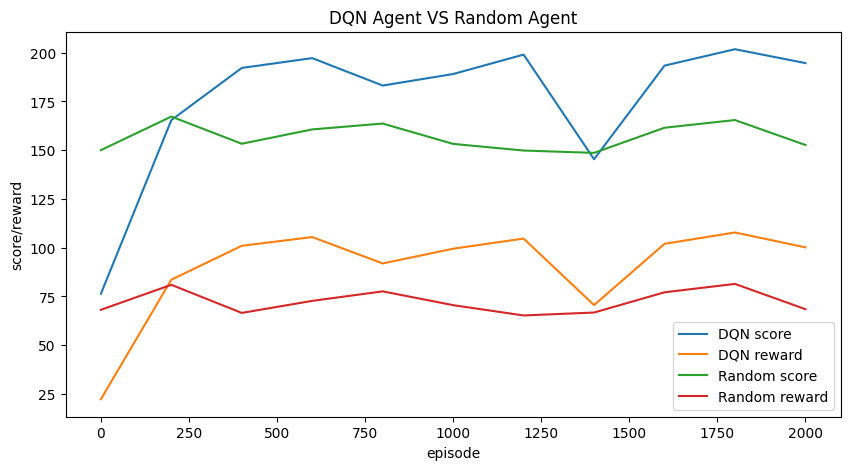

In [24]:
plt.figure(figsize=(10, 5))

plt.plot(x_history, [score for (score, _) in history1], label="DQN score")
plt.plot(x_history, [reward for (_, reward) in history1], label="DQN reward")
plt.plot(x_history, [score for (score, _) in history2], label="Random score")
plt.plot(x_history, [reward for (_, reward) in history2], label="Random reward")

plt.xlabel("episode")
plt.ylabel("score/reward")

plt.title("DQN Agent VS Random Agent")

plt.legend()

plt.show()

其中，可以看出，DQN 智能体在 400 轮后（奖励 $reward$）优于随机智能体，因此可以认为该模型学习到了游戏特点。

在 1400 局时的评估中，$score_{DQN} < score_{Random}$，即模型尚有部分情况处理能力较差。

但由于 $score$ 和 $reward$ 存在差异，在 200 轮后，有 $reward_{DQN} > score_{Random}$。

由于奖励 $reward$ 与分数 $score$ 相关，因此两曲线正相关。

### 6.7 保存模型参数

In [25]:
paddle.save(agent.policy_net.state_dict(), FINAL_PARAM_PATH)

## **七、可视化与模型评估**

### 7.1 特征可视化

通过直观观察特征，进一步理解特征对智能体决策的作用。

#### 7.1.1 特征可视化函数

In [26]:
def visualize_feature(
    feature: np.ndarray, game_resolution: typing.Tuple[int, int]
) -> np.ndarray:
    game_w, game_h = game_resolution
    feature_img = np.zeros(
        (game_h, game_w * 2, 3), dtype=np.uint8
    )  # 初始化特征图

    uw, uh = game_w / feature.shape[1], game_h / feature.shape[0]  # 网格宽高

    _v2c = (
        lambda v: 255 if v > 0 else (0 if v == 0 else int(-v / 13.0 * 255.0))
    )  # 特征值转颜色（单通道）
    value2color = (
        lambda v: (_v2c(v), _v2c(v), _v2c(v))
        if v >= 0
        else (127, _v2c(v), _v2c(v))
    )  # 特征值转颜色（三通道）

    for i in range(feature.shape[0]):
        for j in range(feature.shape[1]):
            # 对特征的每个值，基于值对应的颜色来渲染相应的网格
            feature_img[
                int(i * uh) : int((i + 1) * uh), int(j * uw) : int((j + 1) * uw)
            ] = value2color(feature[i, j, 0])
            feature_img[
                int(i * uh) : int((i + 1) * uh),
                int(j * uw + game_w) : int((j + 1) * uw + game_w),
            ] = value2color(feature[i, j, 1])

            # 绘制特征值文本到对应网格中
            putText2(
                feature_img,
                f"{int(feature[i, j, 0])}",
                (int((j + 0.5) * uw), int((i + 0.5) * uh)),
                font_scale=0.3,
                color=(0, 0, 255),
            )
            putText2(
                feature_img,
                f"{int(feature[i, j, 1])}",
                (int((j + 0.5) * uw + game_w), int((i + 0.5) * uh)),
                font_scale=0.3,
                color=(0, 0, 255),
            )

    # 绘制网格线（横向）
    for i in range(feature.shape[0]):
        cv2.line(
            feature_img,
            (0, int(i * uh)),
            (game_w * 2, int(i * uh)),
            (255, 0, 0),
            1,
        )
    # 绘制最下面的网格线
    cv2.line(
        feature_img, (0, game_h - 1), (game_w * 2, game_h - 1), (255, 0, 0), 1
    )

    # 绘制左半部分网格线（纵向）
    for j in range(feature.shape[1]):
        cv2.line(
            feature_img, (int(j * uw), 0), (int(j * uw), game_h), (0, 255, 0), 1
        )
    # 绘制左半部分的右边界线
    cv2.line(feature_img, (game_w - 1, 0), (game_w - 1, game_h), (0, 255, 0), 1)

    # 绘制右半部分网格线（纵向）
    for j in range(feature.shape[1]):
        cv2.line(
            feature_img,
            (int(j * uw + game_w), 0),
            (int(j * uw + game_w), game_h),
            (0, 255, 0),
            1,
        )

    # 绘制右边界线
    cv2.line(
        feature_img,
        (game_w - 1 + game_w, 0),
        (game_w - 1 + game_w, game_h),
        (0, 255, 0),
        1,
    )

    # 绘制两部分中间的分隔线（较粗）
    cv2.line(feature_img, (game_w, 0), (game_w, game_h), (255, 255, 0), 3)

    return feature_img

### 7.1.2 特征可视化

首先开始一局游戏并进行一些操作。

In [27]:
# 初始化环境
env.reset(11235813)

max_steps = 30
# 预设动作
actions = [(i % GameInterface.ACTION_NUM) for i in range(max_steps)]
feature, _, alive = env.next(0)
rewards_sum = 0

step = 0

while alive and step < max_steps:
    action = actions[step]
    feature, reward, alive = env.next(action)

    step += 1

# 渲染游戏画面
env.game.draw()

print(f"score: {env.game.score}, alive: {env.game.alive}")

score: 69, alive: True


随后分别显示游戏画面与特征可视化的结果。

<Figure size 7200x4800 with 0 Axes>

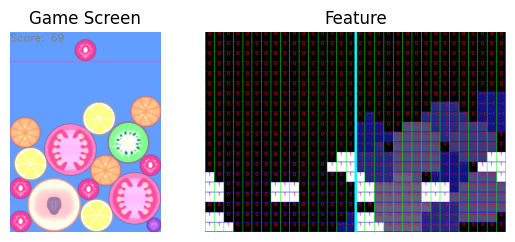

In [28]:
plt.figure(figsize=(12, 8), dpi=600, layout="tight")

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 2]})

ax1.set_title("Game Screen")
ax1.axis("off")

rgb_img = cv2.cvtColor(env.game.screen, cv2.COLOR_BGRA2BGR)

# 左侧显示游戏界面
ax1.imshow(rgb_img[:, :, ::-1])

ax2.set_title("Feature")
ax2.axis("off")

rgb_img = visualize_feature(
    env.game.get_features(
        GameInterface.FEATURE_MAP_WIDTH, GameInterface.FEATURE_MAP_HEIGHT
    ),
    env.game.resolution,
)

# 右侧显示特征图
ax2.imshow(rgb_img[:, :, ::-1])

plt.show()

特征图中，分为左右两部分，使用白色表示和当前水果同类的区域，数值为 1。

左侧用于记录比当前水果小的水果，右侧记录比当前水果大的水果，不满足条件且不为同类的水果在所属特征图中不可见。

以上图为例，当前水果为红色的樱桃，类别为 `2`。

因此特征图中（左右部分分别）有四个区域为白色，对应左图中的四颗樱桃 `2`。

左部记录比当前水果小的：当前图中仅葡萄 `1`（在最右下角）比樱桃 `2` 小，因此其余部分均为黑色 `0` （空白）。

右部记录比当前水果大的：当前图中大多数水果均大于樱桃 `2`，差距越大的水果颜色越浅，可以看到特征图的右部和游戏界面整体表现一致。

### 7.2 评估训练结果

基于给定的 `env` 和 `agent`，进行一定数量局数的游戏。

在游戏结束后，返回每局的平均得分和平均总奖励。

In [29]:
# 评估 200 局，降低偶然性影响
EVALUATE_TIMES = 200

random_agent = RandomAgent(GameInterface.ACTION_NUM)

scores1, rewards1 = [], []
scores2, rewards2 = [], []

for _ in range(EVALUATE_TIMES):
    seed = evaluate_random.random()

    score1, reward1 = evaluate(env, agent, seed)
    scores1.append(score1)
    rewards1.append(reward1)

    score2, reward2 = evaluate(env, random_agent, seed)
    scores2.append(score2)
    rewards2.append(reward2)

print(
    f"""[DQN Agent]\t:\tmean_score: {np.mean(scores1)},\tmean_reward: {np.mean(rewards1)},
\t\t\tmax_score: {np.max(scores1)},\tmax_reward: {np.max(rewards1)},
\t\t\tmin_score: {np.min(scores1)},\tmin_reward: {np.min(rewards1)}"""
)
print(
    f"""[Random Agent]\t:\tmean_score: {np.mean(scores2)},\tmean_reward: {np.mean(rewards2)},
\t\t\tmax_score: {np.max(scores2)},\tmax_reward: {np.max(rewards2)},
\t\t\tmin_score: {np.min(scores2)},\tmin_reward: {np.min(rewards2)}"""
)

[DQN Agent]	:	mean_score: 205.01,	mean_reward: 109.82,
			max_score: 352,	max_reward: 222,
			min_score: 90,	min_reward: 16
[Random Agent]	:	mean_score: 153.215,	mean_reward: 69.67,
			max_score: 322,	max_reward: 194,
			min_score: 57,	min_reward: -16


可以看到，DQN 智能体分数显著优于随机智能体的分数，因此认为该网络能学习到游戏策略。